In [11]:
import time

import tensorflow as tf
import numpy as np

import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import custom_vgg19

In [12]:
def load_image_as_batch_with_optional_resize(path, newH=None, newW=None):
    img = skimage.io.imread(path)
    img = img / 255.0
    
    oldH, oldW = img.shape[0], img.shape[1] # assume h,w is shape[0] and [1] respectively
    if newH != None or newW != None:
        if newW is None:
            newW = int(oldW * float(newH) / oldH)
        elif newH is None:
            newH = int(oldH * float(newW) / oldW)
        img = skimage.transform.resize(img, (newH, newW))
    
    # delete the Alpha channel if the image is RGBA to make sure # channel is correct
    if img.shape[2]==4:
        img = img[:,:,0:3]
        
    # add another dimension to make it a batch , bacause our vgg19 def takes a batch
    img = img.reshape((1,)+img.shape)
    return img

(1, 600, 468, 3)
(1, 256, 256, 3)


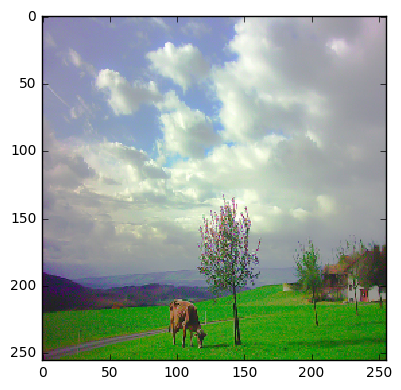

In [13]:
CONTENT_LAYER = 'conv3_2'
STYLE_LAYERS = ('conv1_1', 'conv2_1', 'conv3_1', 'conv4_1')

class ARG:pass
arg = ARG()
arg.gen_img_height=500

styleimg = load_image_as_batch_with_optional_resize('./picasso_selfport1907.jpg')
print(styleimg.shape)
# contentimg = load_image_as_batch_with_optional_resize('./brad_pitt.jpg', newH=arg.gen_img_height)
contentimg = load_image_as_batch_with_optional_resize('data/COCO_test2014_000000000090.jpg', 256,256)
print(contentimg.shape)

arg.gen_img_width = contentimg.shape[1] # computed from aspect ratio of content_img
# show image
skimage.io.imshow(contentimg[0])
plt.show()

In [14]:
sess=tf.Session()
img_pl = tf.placeholder(tf.float32)
vgg19factory = custom_vgg19.Vgg19Factory()
vgg19 = vgg19factory.build(img_pl)

print(styleimg.shape)
conv31feat = sess.run(vgg19.conv3_1, feed_dict={img_pl:styleimg})
print(conv31feat.shape)

/work/04006/zhuode93/maverick/dlproj2/trainable-neural-style/tensorflow_vgg/vgg19.npy
npy file loaded
(1, 600, 468, 3)
(1, 150, 117, 256)


In [15]:
def gram_matrix(feat_map):
    assert isinstance(feat_map, tf.Tensor)
    shape = tf.cast(tf.shape(feat_map), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    F = tf.reshape(feat_map, [-1, tf.cast(ch,tf.int32)])
    
    # TODO: if m<n, compute feat_map*feat_map, else compute feat_map'*feat_map 
    gram = tf.matmul(F, F, transpose_a=True) / h / w / ch # not sure why  we have"/ ch". if not, the style_loss is too big
    return gram

def compute_style_loss(gram_of_feat_map1, feat_map2):
    shape = tf.cast(tf.shape(feat_map2), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    
    G1, G2 = gram_of_feat_map1, gram_matrix(feat_map2)
    style_loss = tf.nn.l2_loss((G1-G2))/ (ch**2) # ch^2 is #element in G1, G2
    return style_loss

def compute_content_loss(feat_map1, feat_map2):
    shape = tf.cast(tf.shape(feat_map1), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    
    content_loss = tf.nn.l2_loss(feat_map1-feat_map2)/h/w/ch
    return content_loss

In [16]:
batch_shape = contentimg.shape
img_gen = tf.Variable(tf.truncated_normal(contentimg.shape,  mean=0.5, stddev=0.1))
vgg19_pred= vgg19factory.build(img_gen)

In [17]:

# precompute content/style image's stuffs
style_layers_target = [getattr(vgg19, l) for l in STYLE_LAYERS]
content_layer_target = getattr(vgg19, CONTENT_LAYER)
styleimg_grams_np = [sess.run(gram_matrix(l), feed_dict={img_pl:styleimg}) for l in style_layers_target]
contentimg_feat_map_np = sess.run(content_layer_target, feed_dict={img_pl:contentimg})
styleimg_grams = [tf.constant(g, dtype=tf.float32) for g in styleimg_grams_np]
contentimg_feat_map = tf.constant(contentimg_feat_map_np, dtype=tf.float32)

style_layers_pred = [getattr(vgg19_pred, name) for name in STYLE_LAYERS]
content_layer_pred = getattr(vgg19_pred, CONTENT_LAYER)

In [18]:
sess.run(img_gen.initializer)

style_losses = [compute_style_loss(src, dst) for (src,dst) in zip(styleimg_grams,style_layers_pred)]
style_loss_np = sess.run(style_losses)
print 'initial style loss: ' + str(style_loss_np)

content_loss = compute_content_loss(contentimg_feat_map, content_layer_pred)
[content_loss_np] =sess.run([content_loss])
print('initial content loss = %f' % content_loss_np)

def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()[1:]), 1)
BATCH_SIZE=1
# total variation denoising
bsize, h , w, ch = batch_shape
y_tv = tf.nn.l2_loss(img_gen[:,1:,:,:] - img_gen[:,:batch_shape[1]-1,:,:])
x_tv = tf.nn.l2_loss(img_gen[:,:,1:,:] - img_gen[:,:,:batch_shape[2]-1,:])
tv_loss = (x_tv + y_tv)/(bsize*h*w*ch)
[tv_loss_np] =sess.run([tv_loss])
print('initial TV loss = %f' % tv_loss_np)

total_loss =  10 * reduce(tf.add, style_losses) + 1.5 * content_loss + 100000 * tv_loss
[total_loss_np] = sess.run([total_loss])
print('initial total loss = %f' % total_loss_np)

initial style loss: [307.38837, 8349.4297, 379.02316, 12478.462]
initial content loss = 7957.171387
initial TV loss = 0.015396
initial total loss = 228618.406250


In [19]:
temp = set(tf.all_variables())
train_op = tf.train.AdamOptimizer(0.02).minimize(total_loss)
#I honestly don't know how else to initialize ADAM in TensorFlow.
sess.run(tf.initialize_variables(set(tf.all_variables()) - temp))

# start optimization
iter = 0
MAX_ITER = 200

while iter < MAX_ITER:
    sess.run(train_op)
    iter += 1
    if iter % 10 == 0:
        print(sess.run([total_loss]+style_losses+ [content_loss, tv_loss]))

[107276.92, 289.99426, 3307.2571, 411.57147, 4667.5923, 12242.352, 0.021492528]
[79333.625, 267.34464, 2404.6021, 241.02638, 2880.3367, 12557.104, 0.02564876]
[56580.277, 200.3741, 1650.9772, 164.84807, 1506.8969, 12602.004, 0.02446308]
[39233.781, 129.2953, 910.7981, 101.23433, 711.54437, 12321.552, 0.022227341]
[28809.709, 72.687782, 450.37311, 60.222294, 397.50418, 11353.819, 0.019711072]
[23640.816, 43.449661, 275.75339, 44.885715, 292.89368, 10234.45, 0.017193167]
[20827.494, 32.474125, 216.23506, 38.895264, 236.88747, 9371.335, 0.015255724]
[19008.713, 28.560658, 186.42114, 36.227798, 203.32809, 8718.1416, 0.013861234]
[17701.111, 26.352213, 162.29826, 34.416893, 181.27467, 8248.7227, 0.012846068]
[16709.24, 24.62698, 143.57538, 33.112461, 165.93633, 7888.1416, 0.012045148]
[15935.1, 23.165289, 129.29124, 32.248119, 155.42949, 7593.8677, 0.011429559]
[15313.533, 21.976233, 118.09086, 31.647982, 147.82426, 7349.3188, 0.010941607]
[14799.999, 21.026806, 109.15752, 31.184261, 142.77

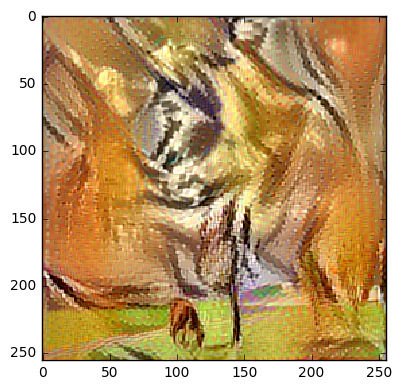

In [20]:

img_gen_clipped = tf.clip_by_value(img_gen, 0,1) #  the range of values in generated image will fall out of [0,1].
            # If you scale it to [0,1] instead of clipping it to [0,1], the image will look "grey"
img_gen_np = np.squeeze(sess.run(img_gen_clipped), 0)
skimage.io.imshow(img_gen_np)
plt.show()